<a href="https://colab.research.google.com/github/PetrGavrilin/VKR_URFU/blob/main/VKR_part5_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Нейронная сеть
</h1>

In [1]:
try:
  from aeon.regression.deep_learning import CNNRegressor
except:
  !pip install aeon
  from aeon.regression.deep_learning import CNNRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 MB 11.7 MB/s eta 0:00:00


In [2]:
# импорт необходимых библиотек
from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

import pandas as pd
import numpy as np

In [3]:
import sys
sys.path.append('/content')

from vkr_function import print_scores, plot_predict, my_features_extraction, my_test_train_split

In [5]:
Y = pd.read_csv('/content/flow_rate.csv')
X_tsfel = np.genfromtxt('/content/X_tsfel.csv', delimiter=',')
X_tsfel_savgol = np.genfromtxt('/content/X_tsfel_savgol.csv', delimiter=',')
borders = pd.read_csv('/content/borders.csv').values.tolist()[0]

In [7]:
X = X_tsfel[1:]
Y = np.array(Y['Et'])
X_train, y_train, X_test, y_test, i_test = my_test_train_split(X, Y, borders)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [8]:
#rgs = CNNRegressor(n_epochs=200, n_layers=3, kernel_size=7, activation='ReLU', n_filters=3)
#rgs = CNNRegressor(n_epochs=200, activation='ReLU', kernel_size=6, n_layers=3, n_filters=[6, 6, 6])
#rgs = CNNRegressor(n_epochs=200, activation='ReLU', kernel_size=6, n_filters=64)
rgs = CNNRegressor(n_epochs=200, n_layers=3, activation='ReLU', kernel_size=6, n_filters=[128,64,64])

In [ ]:
rgs.fit(X_train, y_train)

CNNRegressor(activation='ReLU', kernel_size=6, n_epochs=200,
             n_filters=[128, 64, 64], n_layers=3)

In [ ]:
# Обучение модели и вывод метрик
y_predict=rgs.predict(X_test)
print_scores(y_test, y_predict)


25/25 [==============================] - 0s 15ms/step
Ошибка на тестовых данных
MSE: 0.0018
RMSE: 0.0423
R2 : 0.9965


In [ ]:
y_predict_all = rgs.predict(X)
print_scores(Y, y_predict_all, False)

245/245 [==============================] - 4s 15ms/step
Ошибка на полных данных
MSE: 0.0004
RMSE: 0.0192
R2 : 0.9993


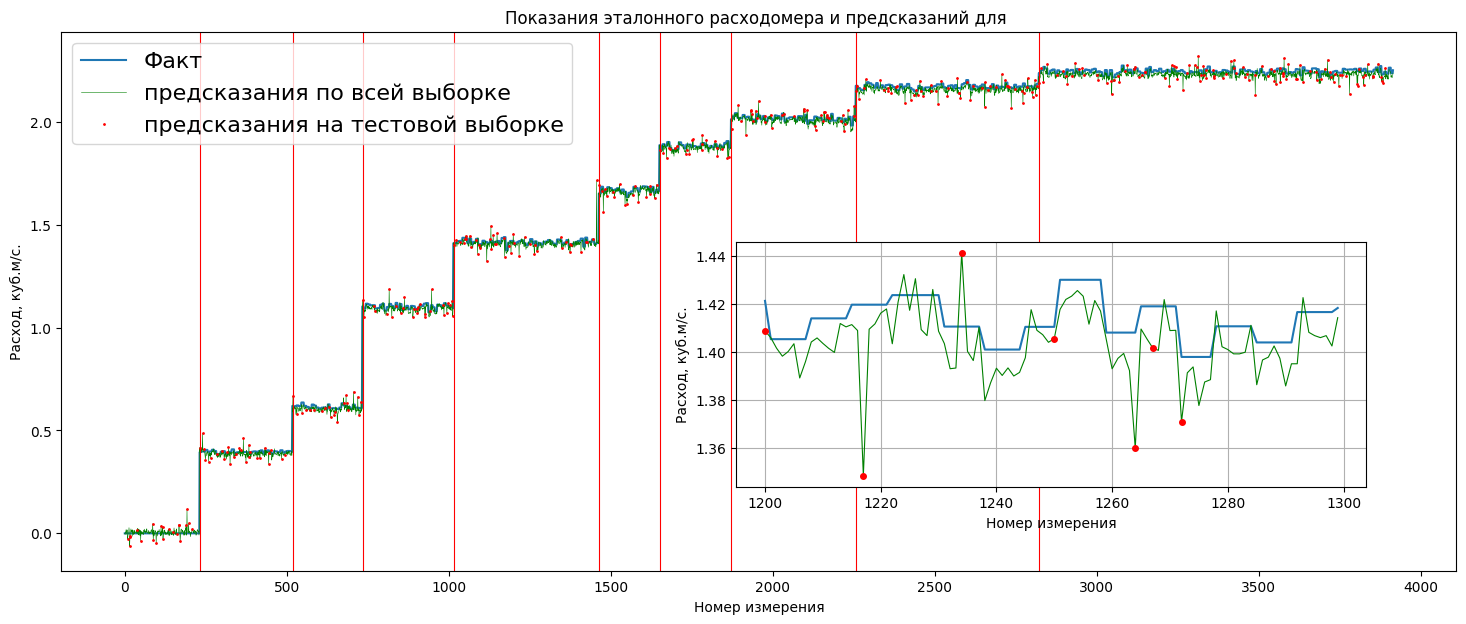

In [ ]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="")

Из колебаний графика предсказаний вокруг фактических данных, а также учитывая построенный ранее график из исходных данных по разности времён, можно предположить, что для исключения колебаний показания расхода необходимо применить сглаживание к исходным данным.

Обучение модели на дополнительно обработанных данных с помощью функции Савицкого-Голея

In [9]:
X = X_tsfel_savgol[1:]
X_train, y_train, X_test, y_test, i_test = my_test_train_split(X, Y, borders)

In [10]:
# обучаем на тренировочных данных
rgs.fit(X_train, y_train)

# предсказываем на тестовых данных
y_predict=rgs.predict(X_test)

print_scores(y_test, y_predict)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 1s 19ms/step
Ошибка на тестовых данных
MSE: 0.00017
RMSE: 0.01287
R2 : 0.99968


In [11]:
y_predict_all = rgs.predict(X)
print_scores(Y, y_predict_all, False)

245/245 [==============================] - 3s 14ms/step
Ошибка на полных данных
MSE: 0.00007
RMSE: 0.00844
R2 : 0.99986


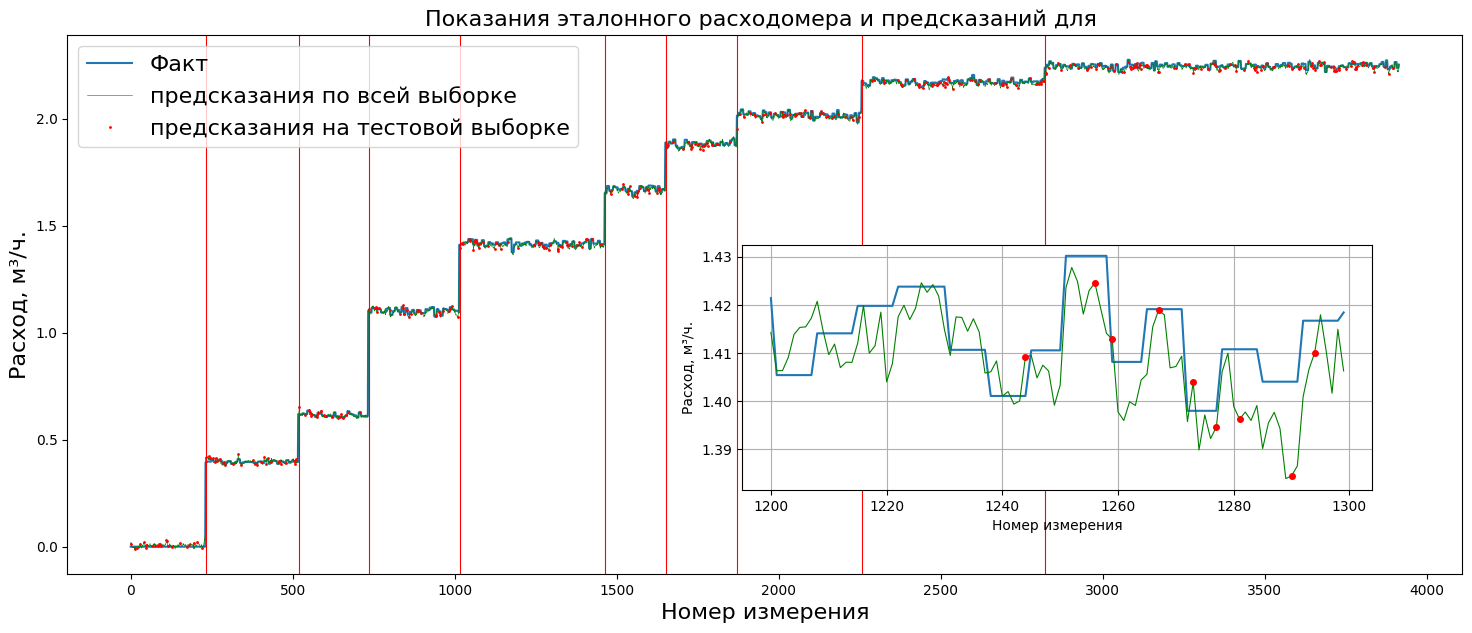

In [12]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="")

Проверим работу модели, приняв за тестовую выборку один из режимов расхода

In [13]:
l_ = len(Y)

i_test = list(range(borders[3],borders[4]))

i_train = list(range(0,l_))
for x1 in i_test:
  i_train.remove(x1)

X_train = X[i_train,:]
y_train = Y[i_train]

X_test = X[i_test,:]
y_test = Y[i_test]

print(len(X_train), len(y_train))

3466 3466


In [14]:
# обучаем на тренировочных данных
rgs.fit(X_train, y_train)

# предсказываем на тестовых данных
y_predict=rgs.predict(X_test)

print_scores(y_test, y_predict)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 11ms/step
Ошибка на тестовых данных
MSE: 0.02290
RMSE: 0.15132
R2 : -87.22430


In [15]:
y_predict_all = rgs.predict(X)
print_scores(Y, y_predict_all, False)

245/245 [==============================] - 3s 10ms/step
Ошибка на полных данных
MSE: 0.00288
RMSE: 0.05370
R2 : 0.99442


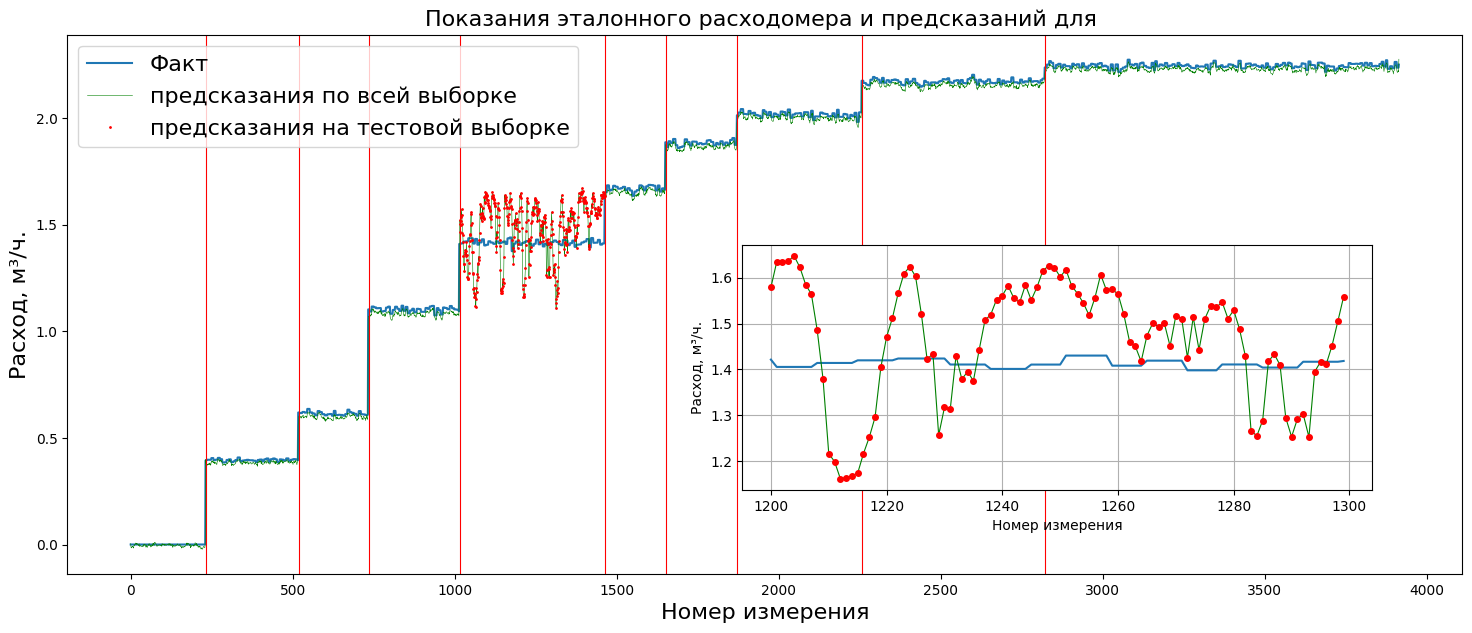

In [16]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="")

In [17]:
Y[1015:1464].sum()/(1464-1015)

1.4169322693003341

In [18]:
y_predict_all[1015:1464].sum()/(1464-1015)

1.4807270279440423